In [1]:
import torch 
from torch.utils.data import DataLoader 
import numpy as np 
from typing import List, Optional, Tuple 
import sys 
from tqdm import tqdm 
sys.path.insert(0, "../../")
from DEFAULTS import BASE_PATH 
from loaders import get_dataset 
from model_builder import get_pretrained_model_v2 

DATASET = "neural-activity-states"
MODEL = "mae-lightning-small"
WEIGHTS = "MAE_SMALL_STED"
GLOBAL_POOL = "avg"
INIT_K = 4 
RECURSIVE_K = 2 
CLASSES = ["Block", "0Mg", "GluGly", "48hTTX"]

/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Running on {DEVICE} ---")
model, cfg = get_pretrained_model_v2(
    name=MODEL,
    weights=WEIGHTS,
    path=None, 
    mask_ratio=0.0, 
    pretrained=True if "imagenet" in WEIGHTS.lower() else False,
    in_channels=3 if "imagenet" in WEIGHTS.lower() else 1,
    as_classifier=True,
    blocks="all",
    num_classes=4,
)
model.to(DEVICE)
model.eval()
print(model)

--- Running on cuda ---
mask_ratio 0.0
pretrained False
in_channels 1
blocks all
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---
LinearProbe(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in

### Load dataset

In [3]:
train_loader, valid_loader, test_loader = get_dataset(
    name=DATASET, 
    transform=None,
    training=True,
    path=None,
    batch_size=cfg.batch_size,
    n_channels=3 if "imagenet" in WEIGHTS.lower() else 1,
)

Processing dataset..: 100%|██████████| 6338/6338 [00:05<00:00, 1202.56it/s]


['0MgGlyBic' '48hTTX' 'Block' 'GluGly'] [1626 2666 1625  421]


Processing dataset..: 100%|██████████| 1164/1164 [00:01<00:00, 954.03it/s] 


['0MgGlyBic' '48hTTX' 'Block' 'GluGly'] [422 405 224 113]


Processing dataset..: 100%|██████████| 1879/1879 [00:01<00:00, 1459.60it/s]

['0MgGlyBic' '48hTTX' 'Block' 'GluGly'] [254 710 624 291]

=== NAS dataset ===
(array([0, 1, 2, 3]), array([421, 421, 421, 421]))
(array([0, 1, 2, 3]), array([113, 113, 113, 113]))
(array([0, 1, 2, 3]), array([254, 254, 254, 254]))
Training size: 1684
Validation size: 452
Test size: 1016




### Embed dataset using pre-trained model

In [4]:
embeddings, labels, depth_0_indices = [], [], []
with torch.no_grad():
    for img, metadata in tqdm(test_loader):
        img = img.to(DEVICE)
        label = metadata["label"] 
        data_index = metadata["dataset-idx"] 
        condition = metadata["condition"]
        print(label, condition)
        output = model.forward_features(img)
        embeddings.extend(output.data.cpu().numpy())
        labels.extend(label)
        depth_0_indices.extend(data_index)
embeddings = np.array(embeddings)
labels = np.array(labels)
depth_0_indices = np.array(depth_0_indices)
print(embeddings.shape, labels.shape, depth_0_indices.shape)
assert embeddings.shape[0] == labels.shape[0] == depth_0_indices.shape[0]

  0%|          | 0/4 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 2, 1, 2, 0, 0, 1, 2, 0, 3, 1, 2, 3, 1, 0, 3, 0, 3, 0, 1, 2,
        3, 0, 3, 0, 0, 0, 0, 2, 2, 2, 3, 3, 3, 0, 2, 2, 0, 0, 3, 1, 0, 1, 0, 2,
        3, 2, 2, 2, 3, 0, 3, 1, 2, 2, 0, 2, 0, 2, 2, 2, 3, 0, 2, 3, 1, 2, 2, 3,
        3, 3, 3, 1, 0, 3, 2, 1, 2, 0, 2, 3, 0, 1, 2, 2, 0, 0, 0, 0, 3, 3, 3, 0,
        2, 2, 3, 3, 2, 3, 1, 1, 2, 1, 0, 0, 0, 2, 2, 1, 0, 0, 2, 0, 3, 0, 0, 3,
        0, 0, 2, 3, 1, 1, 2, 0, 0, 2, 1, 0, 0, 3, 1, 1, 0, 1, 2, 0, 3, 1, 3, 2,
        2, 3, 3, 1, 2, 1, 0, 1, 2, 0, 3, 2, 1, 2, 3, 0, 0, 3, 3, 0, 2, 2, 3, 2,
        1, 0, 2, 3, 3, 2, 2, 1, 3, 1, 2, 1, 2, 0, 0, 2, 3, 2, 0, 1, 1, 2, 2, 0,
        2, 2, 3, 2, 0, 0, 2, 0, 1, 0, 1, 0, 0, 3, 1, 3, 1, 0, 3, 2, 0, 1, 0, 2,
        3, 0, 2, 3, 3, 1, 2, 1, 1, 2, 2, 1, 2, 0, 1, 2, 3, 0, 2, 1, 3, 3, 0, 2,
        1, 2, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 3, 3, 1, 0]) ['48hTTX', '48hTTX', '48hTTX', '48hTTX', 'GluGly', '0MgGlyBic', 'GluGly', 'Block', 'Block', '0MgGlyBic', 'GluGly', 'Block', '48hTTX', '0MgGlyBi

 25%|██▌       | 1/4 [00:00<00:02,  1.33it/s]

tensor([3, 0, 2, 0, 2, 1, 1, 0, 3, 3, 2, 0, 3, 3, 2, 3, 3, 1, 2, 1, 2, 0, 3, 2,
        0, 2, 0, 2, 3, 2, 2, 2, 0, 1, 1, 2, 1, 3, 2, 0, 2, 1, 1, 0, 0, 1, 2, 1,
        2, 1, 2, 3, 2, 0, 1, 2, 3, 0, 0, 1, 2, 1, 2, 3, 3, 2, 0, 3, 3, 2, 3, 0,
        1, 3, 0, 3, 0, 1, 0, 1, 3, 2, 0, 2, 0, 2, 1, 1, 1, 3, 3, 0, 2, 1, 2, 0,
        3, 2, 0, 2, 0, 0, 1, 2, 2, 3, 1, 3, 3, 2, 3, 2, 2, 3, 1, 2, 1, 1, 1, 3,
        3, 3, 2, 2, 0, 3, 2, 2, 3, 1, 1, 3, 2, 2, 0, 3, 3, 1, 3, 2, 1, 1, 2, 2,
        3, 0, 0, 2, 0, 3, 3, 2, 1, 3, 3, 3, 0, 1, 2, 2, 1, 3, 3, 1, 0, 0, 0, 1,
        0, 2, 3, 0, 3, 3, 1, 0, 3, 2, 3, 0, 1, 0, 1, 0, 1, 3, 2, 0, 2, 0, 2, 0,
        2, 2, 0, 1, 1, 1, 1, 0, 1, 0, 3, 3, 0, 1, 2, 0, 2, 1, 0, 1, 1, 0, 1, 1,
        0, 3, 0, 3, 2, 3, 0, 1, 1, 0, 2, 2, 0, 2, 3, 1, 2, 0, 1, 1, 0, 1, 0, 0,
        3, 3, 3, 3, 1, 2, 3, 0, 1, 1, 3, 1, 2, 1, 1, 1]) ['48hTTX', 'Block', 'GluGly', 'Block', 'GluGly', '0MgGlyBic', '0MgGlyBic', 'Block', '48hTTX', '48hTTX', 'GluGly', 'Block', '48hTTX', '48hTTX', 

 50%|█████     | 2/4 [00:01<00:01,  1.86it/s]

tensor([1, 3, 1, 0, 0, 0, 0, 1, 3, 1, 0, 1, 3, 3, 1, 2, 3, 0, 3, 2, 3, 3, 2, 0,
        2, 3, 1, 3, 0, 2, 2, 0, 0, 1, 0, 2, 3, 3, 3, 0, 1, 2, 1, 1, 3, 2, 3, 0,
        0, 0, 0, 2, 0, 0, 2, 0, 0, 3, 1, 1, 3, 3, 2, 1, 0, 1, 0, 2, 2, 0, 1, 2,
        1, 2, 2, 2, 3, 0, 1, 0, 0, 3, 1, 1, 2, 0, 0, 1, 0, 1, 0, 0, 3, 1, 0, 2,
        2, 2, 1, 3, 1, 2, 0, 2, 3, 2, 3, 0, 0, 0, 0, 3, 0, 1, 2, 2, 1, 1, 2, 1,
        3, 1, 3, 1, 3, 0, 2, 1, 2, 3, 2, 2, 2, 3, 3, 1, 0, 0, 1, 3, 2, 3, 2, 1,
        3, 2, 1, 1, 0, 3, 2, 1, 0, 0, 1, 3, 0, 0, 2, 3, 1, 1, 0, 3, 2, 2, 3, 1,
        1, 1, 3, 3, 1, 1, 0, 3, 2, 1, 3, 0, 1, 1, 2, 0, 2, 0, 0, 2, 0, 1, 3, 3,
        0, 0, 1, 1, 1, 3, 1, 2, 2, 1, 3, 0, 1, 3, 2, 2, 3, 3, 0, 0, 1, 2, 0, 0,
        3, 0, 0, 0, 3, 1, 0, 3, 1, 1, 2, 2, 0, 1, 0, 0, 1, 0, 2, 3, 0, 0, 2, 0,
        1, 0, 3, 1, 3, 0, 3, 0, 3, 0, 2, 2, 2, 2, 0, 0]) ['0MgGlyBic', '48hTTX', '0MgGlyBic', 'Block', 'Block', 'Block', 'Block', '0MgGlyBic', '48hTTX', '0MgGlyBic', 'Block', '0MgGlyBic', '48hTTX', '4

 75%|███████▌  | 3/4 [00:01<00:00,  2.16it/s]

tensor([1, 1, 3, 0, 1, 2, 1, 1, 0, 1, 2, 2, 2, 3, 1, 1, 2, 3, 3, 2, 3, 1, 1, 1,
        2, 1, 2, 3, 3, 3, 2, 2, 2, 0, 3, 3, 1, 0, 2, 1, 3, 2, 2, 3, 0, 3, 0, 1,
        3, 2, 1, 3, 1, 1, 3, 0, 1, 2, 1, 0, 3, 1, 2, 3, 3, 2, 2, 3, 2, 0, 1, 1,
        0, 3, 3, 3, 2, 1, 3, 1, 1, 2, 3, 0, 0, 1, 1, 3, 1, 0, 0, 1, 0, 1, 1, 1,
        2, 1, 1, 2, 3, 1, 0, 3, 2, 1, 0, 0, 0, 1, 3, 3, 3, 1, 3, 2, 1, 3, 3, 1,
        3, 3, 1, 2, 1, 2, 2, 3, 0, 1, 2, 0, 2, 3, 2, 3, 2, 3, 0, 3, 3, 3, 1, 1,
        2, 2, 2, 3, 3, 0, 3, 3, 3, 0, 3, 1, 1, 3, 0, 2, 0, 3, 2, 1, 3, 0, 1, 2,
        2, 3, 3, 2, 1, 0, 1, 1, 0, 0, 2, 2, 3, 0, 2, 3, 1, 3, 0, 3, 0, 1, 1, 1,
        2, 2, 2, 1, 1, 0, 0, 3, 3, 3, 0, 3, 1, 1, 2, 3, 3, 2, 1, 0, 3, 2, 3, 3,
        0, 1, 1, 1, 1, 2, 2, 1, 3, 2, 0, 1, 3, 0, 0, 2, 0, 1, 1, 1, 3, 1, 2, 3,
        3, 2, 2, 1, 0, 3, 2, 0]) ['0MgGlyBic', '0MgGlyBic', '48hTTX', 'Block', '0MgGlyBic', 'GluGly', '0MgGlyBic', '0MgGlyBic', 'Block', '0MgGlyBic', 'GluGly', 'GluGly', 'GluGly', '48hTTX', '0MgGlyBic

100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

(1016, 384) (1016,) (1016,)


### Recursive Hierarchical Clustering 
##### Depth 0

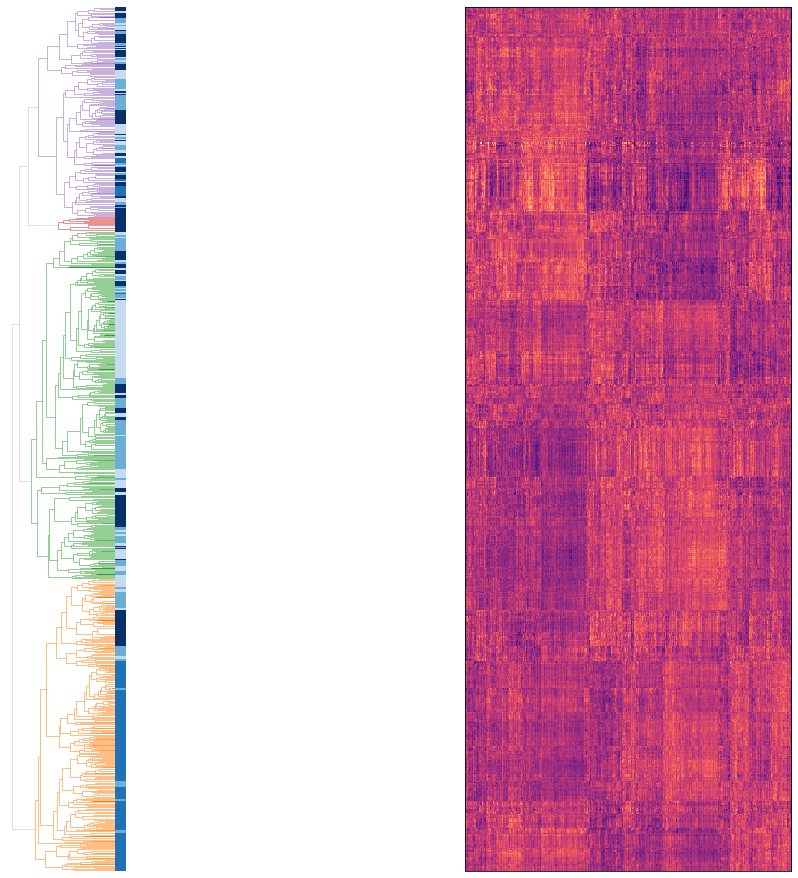

In [5]:
from scipy.cluster import hierarchy 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 

DEPTH = 0

if labels.dtype == np.float32:
    labels = labels.astype(np.int8)
uniques = np.unique(labels)
D = embeddings 
D = StandardScaler().fit_transform(D)
Y1 = hierarchy.linkage(D, method="average", metric="cosine")
clusters_0 = hierarchy.fcluster(Y1, INIT_K, criterion="maxclust")

distances = Y1[:, 2]
threshold = distances[-(INIT_K - 1)]
Y2 = hierarchy.linkage(D.T, method="average", metric="cosine")

fig = plt.figure(figsize=(15, 15))
ax3 = fig.add_axes([0, 0, 0.1, 0.8])
ax3.set_xticks([])
ax3.set_yticks([])
fig.gca().invert_xaxis() 
ax3.axis("off")

Z1 = hierarchy.dendrogram(
    Y1, orientation="left",
    above_threshold_color="silver",
    ax=ax3,
    color_threshold=threshold
)
Z2 = hierarchy.dendrogram(
    Y2, orientation="right",
    above_threshold_color="silver",
    no_plot=True
)
for collection in ax3.collections:
    collection.set_linewidth(0.5)

ax4 = fig.add_axes([0.1,0,0.01, 0.8])
ax4.set_xticks([])
ax4.set_yticks([])
ax4.axis('off')

cmap = plt.get_cmap("Blues", len(set(uniques)) + 1)
all_colors = []
for i, leaf in enumerate(Z1["leaves"]):
    all_colors.append(cmap(labels[leaf] + 1))
    ax4.barh(i + 0.5, 1, 1.0, color=cmap(labels[leaf] + 1))
#     # ax4.axhline(i + 0.5, color=cmap(GROUPS_MODEL[groups[leaf]] + 1))
ax4.set(
    ylim=(0, len(Z1["leaves"])), xlim=(0, 1)
)
ax4.invert_yaxis()
    

axmatrix2 = fig.add_axes([0.15,0,0.85, 0.8])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

sorted_co_matrix = D[idx1,:]
sorted_co_matrix = sorted_co_matrix[:, idx2]
im2 = axmatrix2.matshow(sorted_co_matrix, aspect='equal', origin='lower', cmap="magma")
axmatrix2.set_xticks([])
axmatrix2.set_yticks([])
fig.gca().invert_yaxis() # this plus the x-axis invert in the right-flipped dendrogram flips the y-axis

1 [83, 101, 21, 139]
2 [167, 126, 0, 115]
3 [4, 13, 0, 0]
4 [0, 14, 233, 0]


<ipython-input-6-968781550c87>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(CLASSES, rotation=25)


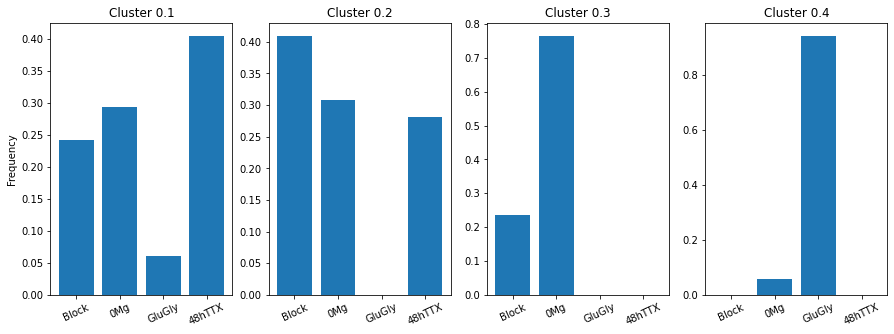

In [6]:
def compute_frequencies(clusters, labels, depth):
    frequencies = {
        key: [0] * INIT_K for key in np.unique(clusters)
    }
    num_clusters = len(np.unique(clusters))
    for cluster_id, true_label in zip(clusters, labels):
        frequencies[cluster_id][true_label] += 1
    for key, value in frequencies.items():
        print(key, value)
    fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))
    for i in range(num_clusters):
        total = sum(frequencies[i+1])
        axs[i].bar(CLASSES, [item / total for item in frequencies[i+1]])
        axs[i].set_title(f"Cluster {depth}.{i+1}")
        axs[i].set_xticklabels(CLASSES, rotation=25)
        axs[0].set_ylabel("Frequency")
    plt.show()

compute_frequencies(clusters_0, labels, depth=DEPTH)

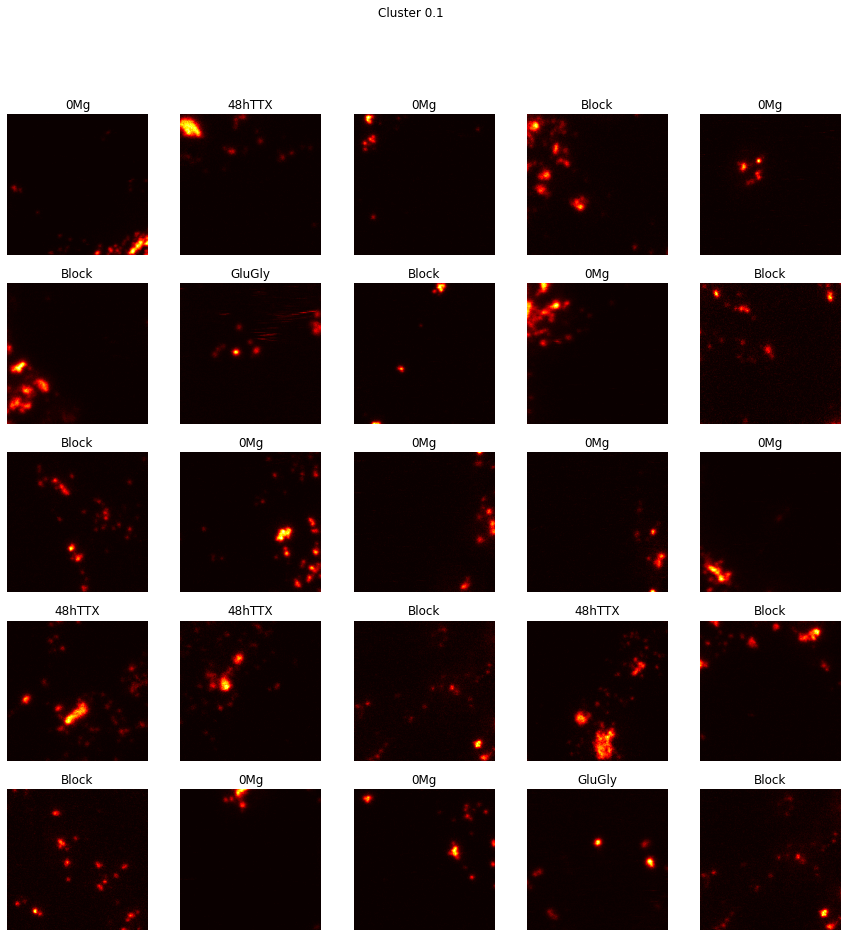

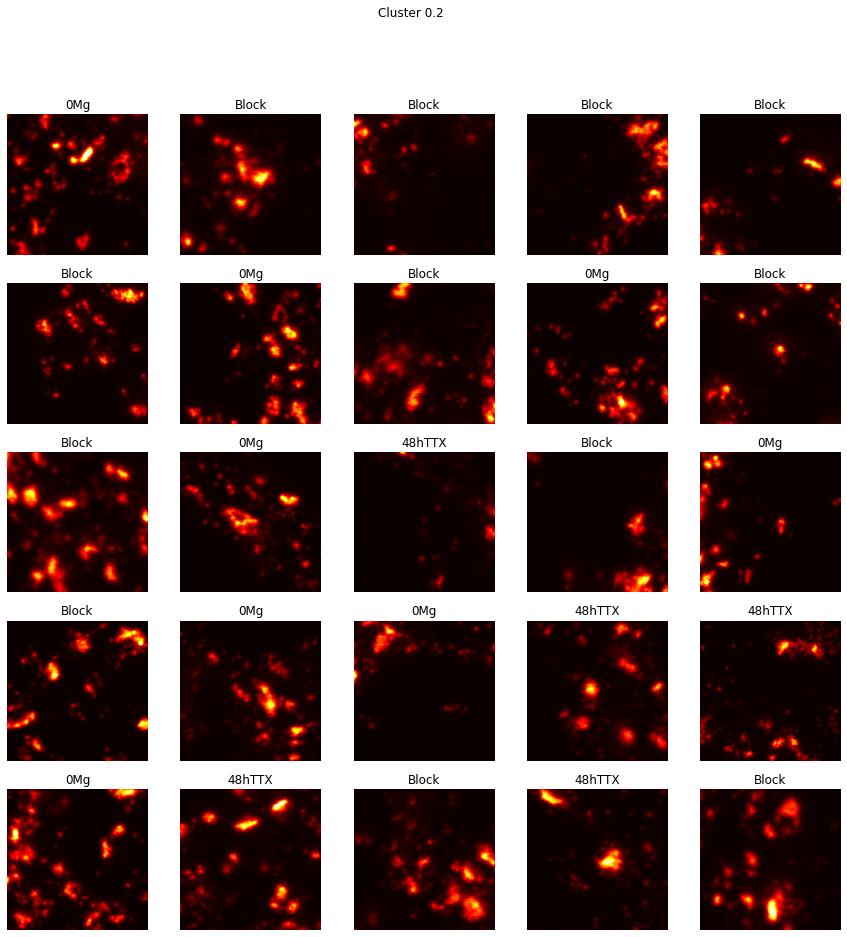

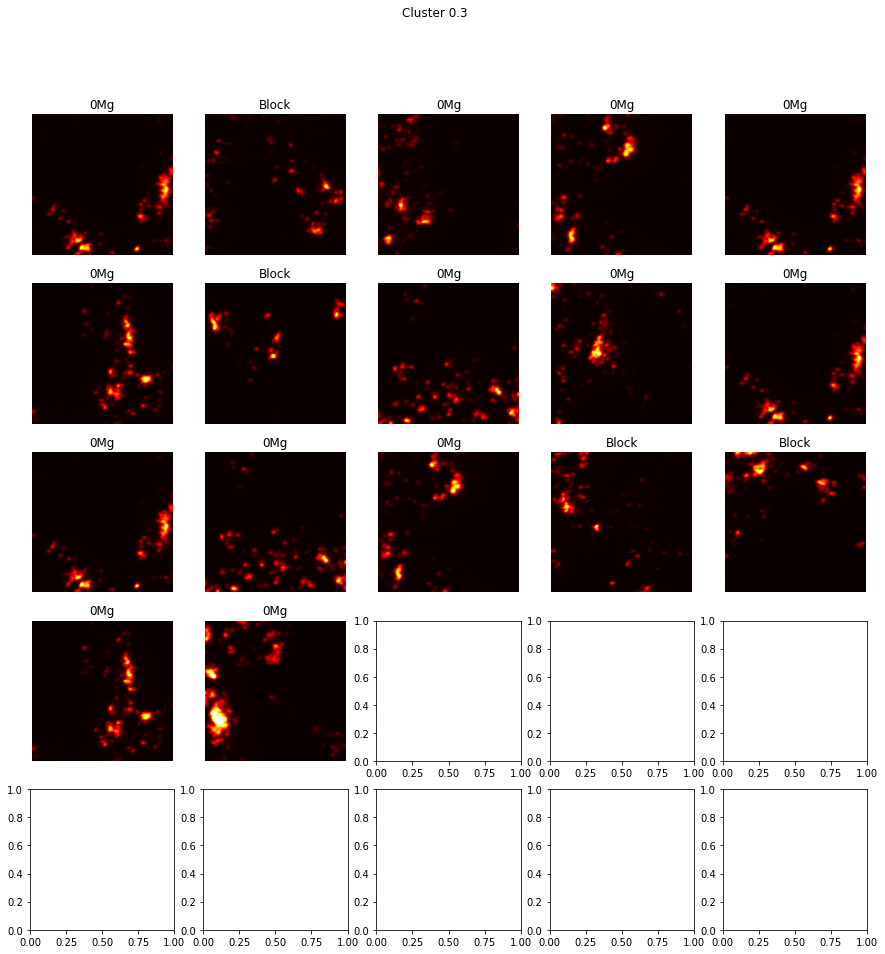

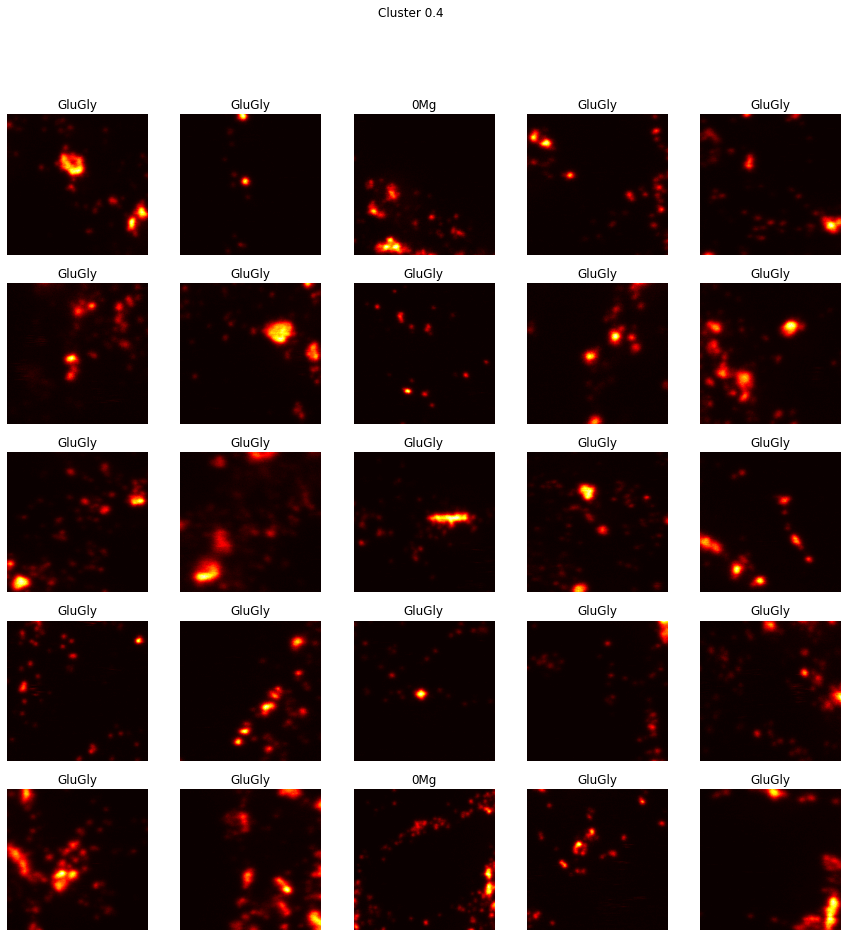

In [8]:
def show_examples(clusters, dataset_indices, depth):
    for cluster_id in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster_id)[0]
        data_ids = dataset_indices[cluster_indices]
        indices = np.random.choice(data_ids, size=min(25, len(data_ids)), replace=False)
        fig, axs = plt.subplots(5, 5, figsize=(15, 15))
        for i, idx in enumerate(indices):
            ax = axs.ravel()[i]
            img = test_loader.dataset[idx][0]
            label = test_loader.dataset[idx][1]["label"]
            img = img.squeeze().cpu().numpy()
            ax.imshow(img, cmap='hot')
            ax.axis("off")
            ax.set_title(CLASSES[label])
        fig.suptitle(f"Cluster {depth}.{cluster_id}")
        plt.show()

show_examples(clusters_0, dataset_indices=depth_0_indices, depth=DEPTH)

In [13]:
from skimage import measure 
from wavelet import detect_spots 

def compute_feature_vectors(clusters):
    all_features = np.zeros((len(clusters), 5))
    feature_vectors = {key: [] * len(np.unique(clusters)) for key in np.unique(clusters)}
    for cluster_id in tqdm(np.unique(clusters)):
        indices = np.where(clusters == cluster_id)[0]
        for idx in indices:
            data_index = depth_0_indices[idx]
            img = test_loader.dataset[data_index][0]
            label = test_loader.dataset[data_index][1]["label"]
            img = img.squeeze().cpu().numpy()
            mask = detect_spots(img)
            mask_label, num_proteins = measure.label(mask, return_num=True)
            region_props = measure.regionprops(mask_label, intensity_image=img)
            img_area, img_perimeter, img_eccentricity, img_intensity, img_proteins = [], [], [], [], num_proteins
            for prop in region_props:
                img_area.append(prop.area)
                img_perimeter.append(prop.perimeter)
                img_eccentricity.append(prop.eccentricity)
                img_intensity.append(prop.mean_intensity)
            img_area = np.mean(img_area)
            img_perimeter = np.mean(img_perimeter)
            img_eccentricity = np.mean(img_eccentricity)
            img_intensity = np.mean(img_intensity)
            all_features[idx] = [img_area, img_perimeter, img_eccentricity, img_intensity, num_proteins]
            feature_vectors[cluster_id].append(all_features[idx])

    for key in feature_vectors.keys():
        data = np.array(feature_vectors[key])
        feature_vectors[key] = np.mean(data, axis=0)
    return all_features, feature_vectors

def plot_feature_vectors(feature_vectors, min_vectors, max_vectors, feature_names: List[str] = ["Area", "Perimeter", "Eccentricity", "Intensity", "# Proteins"]):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    keys = list(feature_vectors.keys())
    feature_vectors = np.array(list(feature_vectors.values()))
    normalized_feature_vectors = (feature_vectors - min_vectors) / (max_vectors - min_vectors)
    im = ax.imshow(normalized_feature_vectors, cmap="RdPu", aspect="auto")
    plt.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(len(feature_names)))
    ax.set_yticks([k - 1 for k in keys])
    ax.set_xticklabels(feature_names, rotation=45, ha='right')
    ax.set_yticklabels([f'Cluster {i+1}' for i in range(len(keys))])

    plt.title('Feature Values by Cluster (Normalized per Feature)')
    plt.tight_layout()
    plt.show()




In [14]:
all_features, feature_vectors = compute_feature_vectors(clusters_0)
feature_mins = np.quantile(all_features, 0.05, axis=0)
feature_maxs = np.quantile(all_features, 0.95, axis=0)

100%|██████████| 4/4 [00:19<00:00,  4.96s/it]


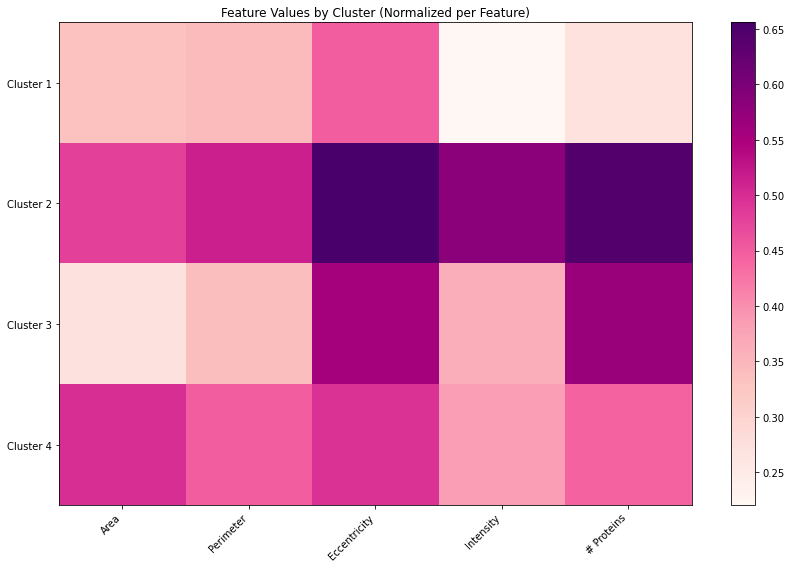

In [15]:
plot_feature_vectors(feature_vectors=feature_vectors, min_vectors=feature_mins, max_vectors=feature_maxs)

##### Depth 1

In [17]:
depth_1_indices = {
    key: [] for key in np.unique(clusters_0)
}
embeddings_1 = {
    key: None for key in np.unique(clusters_0)
}
labels_1 = {
    key: None for key in np.unique(clusters_0)
}
for cluster_id in np.unique(clusters_0):
    indices = np.where(clusters_0 == cluster_id)[0]
    cluster_embeddings = []
    cluster_labels = []
    for i, idx in enumerate(indices):
        data_index = depth_0_indices[idx]
        depth_1_indices[cluster_id].append(data_index)
        img = test_loader.dataset[data_index][0]
        label = test_loader.dataset[data_index][1]["label"]
        img = img.unsqueeze(0).to(DEVICE) 
        output = model.forward_features(img)
        cluster_embeddings.extend(output.data.cpu().numpy())
        cluster_labels.append(label)
    cluster_embeddings = np.array(cluster_embeddings)
    cluster_labels = np.array(cluster_labels)
    embeddings_1[cluster_id] = cluster_embeddings
    labels_1[cluster_id] = cluster_labels

In [18]:
def cluster_embeddings(embeddings):
    D = embeddings
    D = StandardScaler().fit_transform(D)
    Y1 = hierarchy.linkage(D, method="average", metric="cosine")
    clusters = hierarchy.fcluster(Y1, RECURSIVE_K, criterion="maxclust")
    return clusters

clusters_1 = {key: cluster_embeddings(embeddings_1[key]) for key in embeddings_1.keys()}

1 [30, 16, 19, 26]
2 [53, 85, 2, 113]


<ipython-input-6-968781550c87>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(CLASSES, rotation=25)


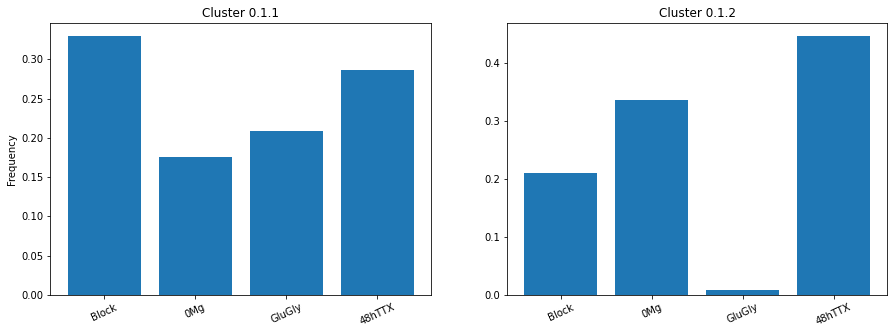

1 [99, 24, 0, 29]
2 [68, 102, 0, 86]


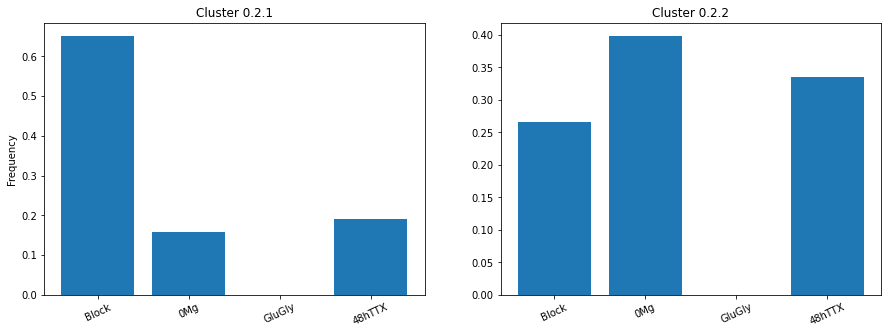

1 [4, 5, 0, 0]
2 [0, 8, 0, 0]


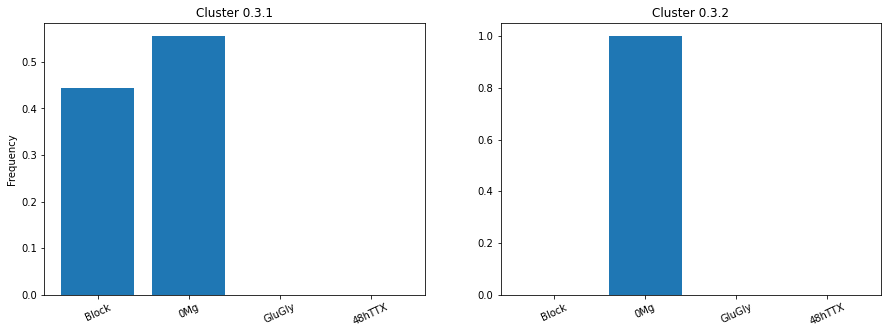

1 [0, 10, 106, 0]
2 [0, 4, 127, 0]


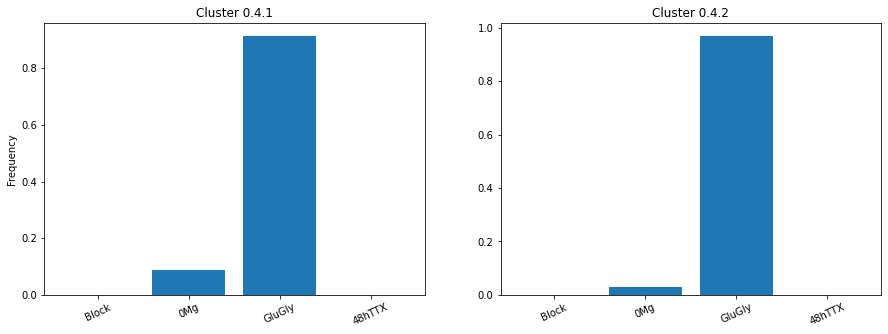

In [19]:
for key in clusters_1.keys():
    clusters = clusters_1[key]
    labels = labels_1[key]
    compute_frequencies(clusters, labels, depth=f"{DEPTH}.{key}")
    

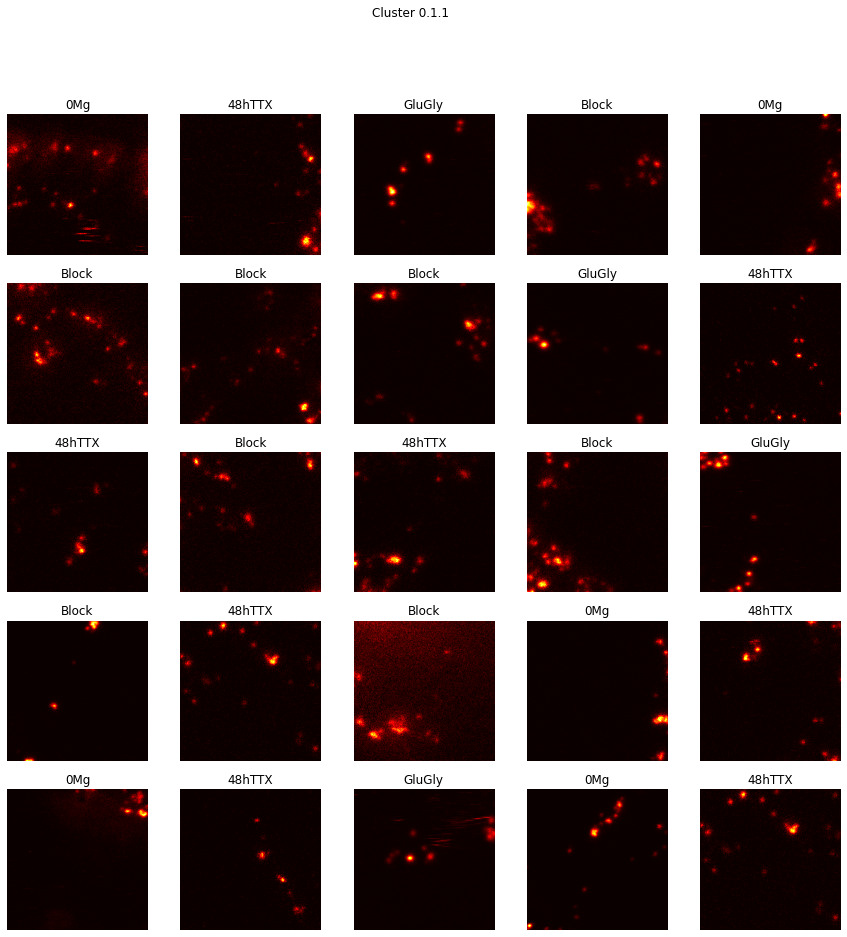

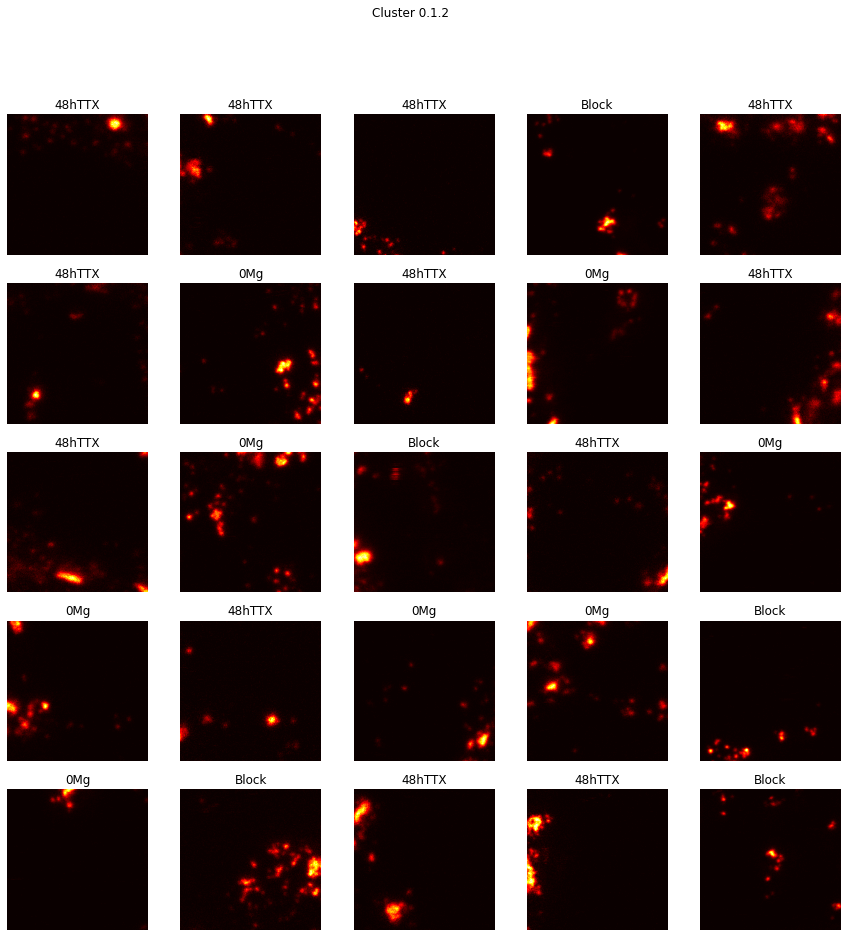

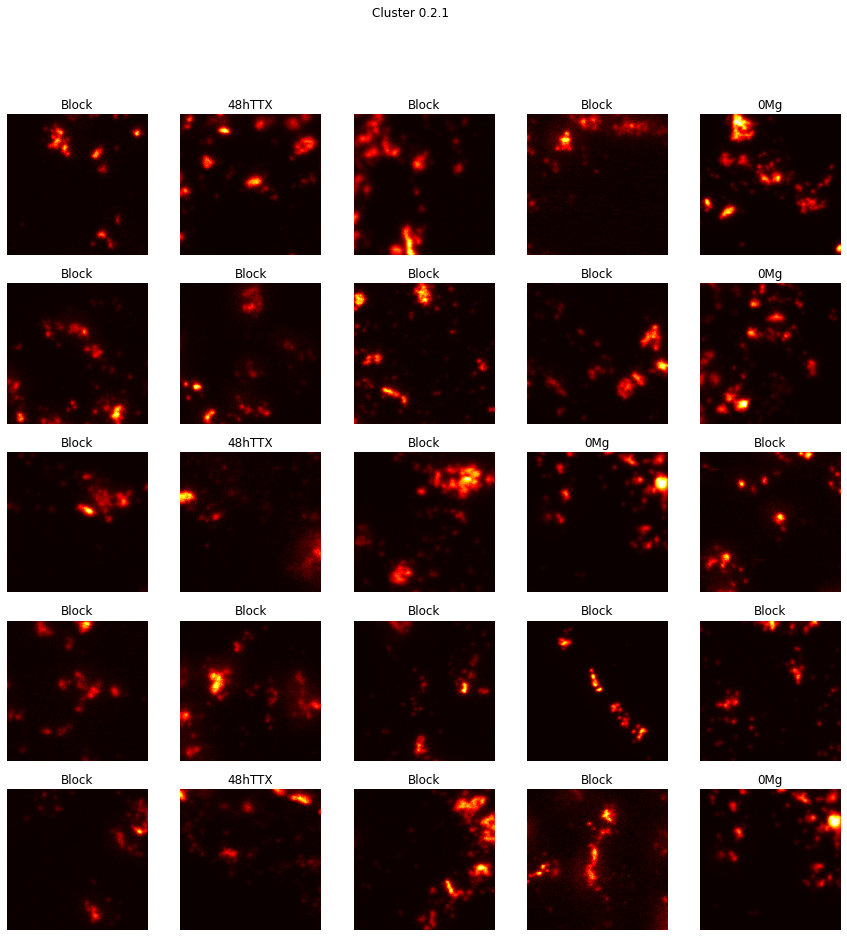

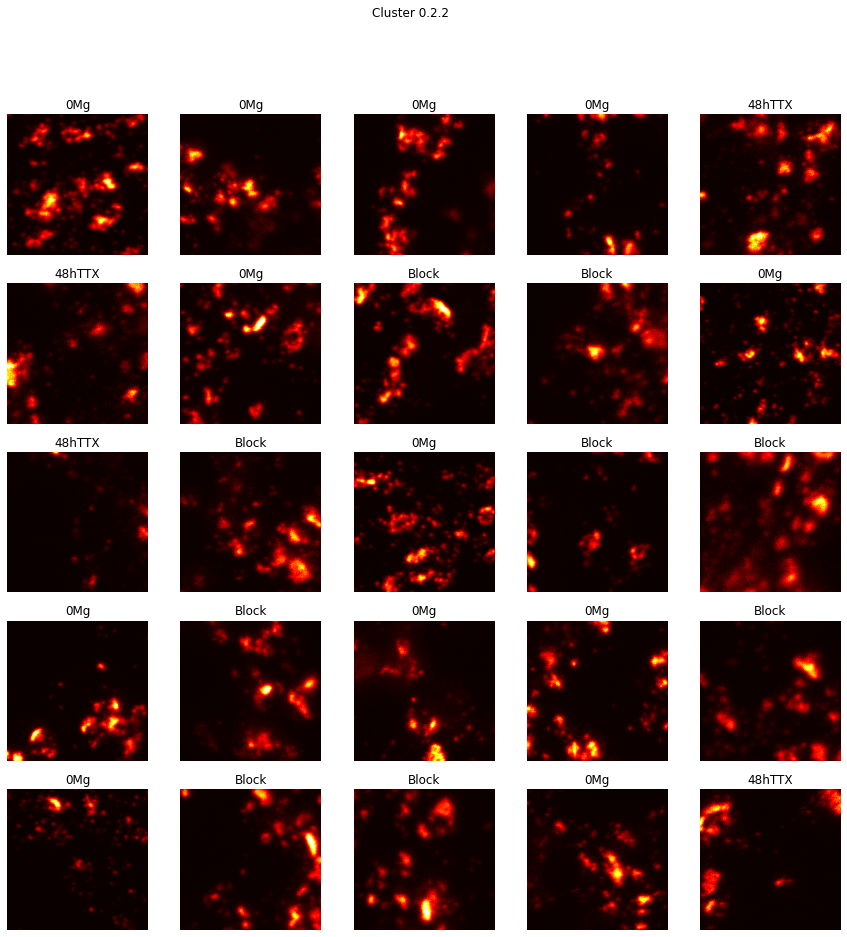

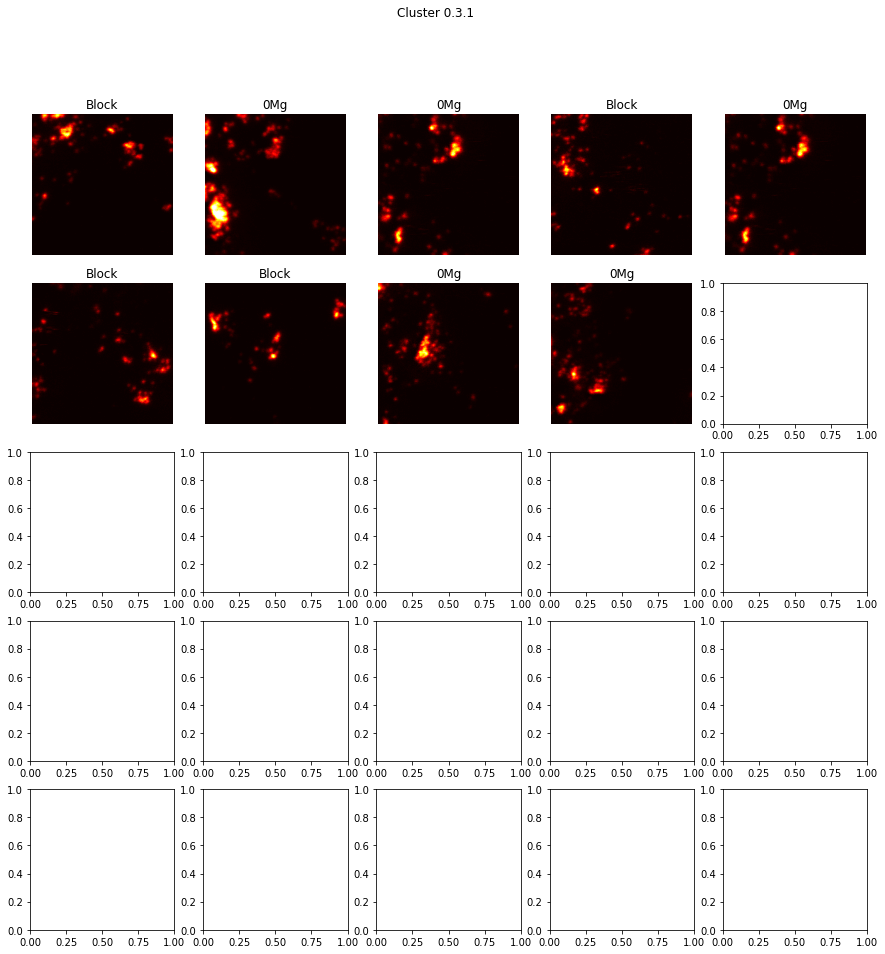

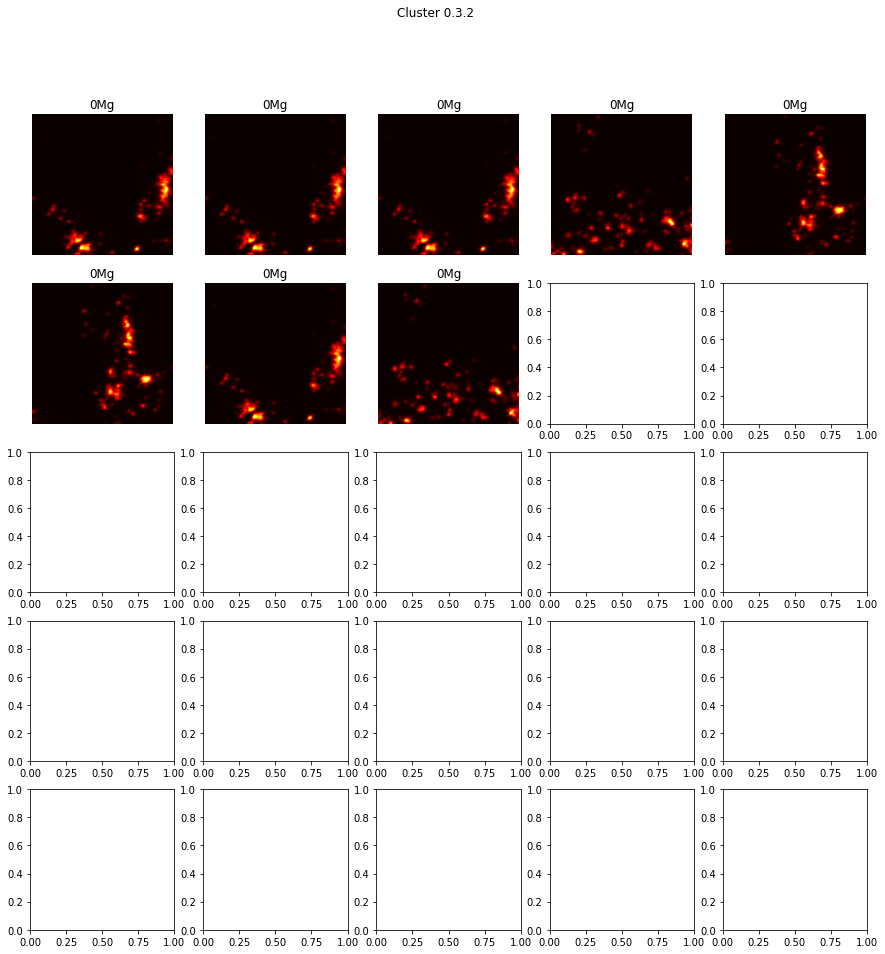

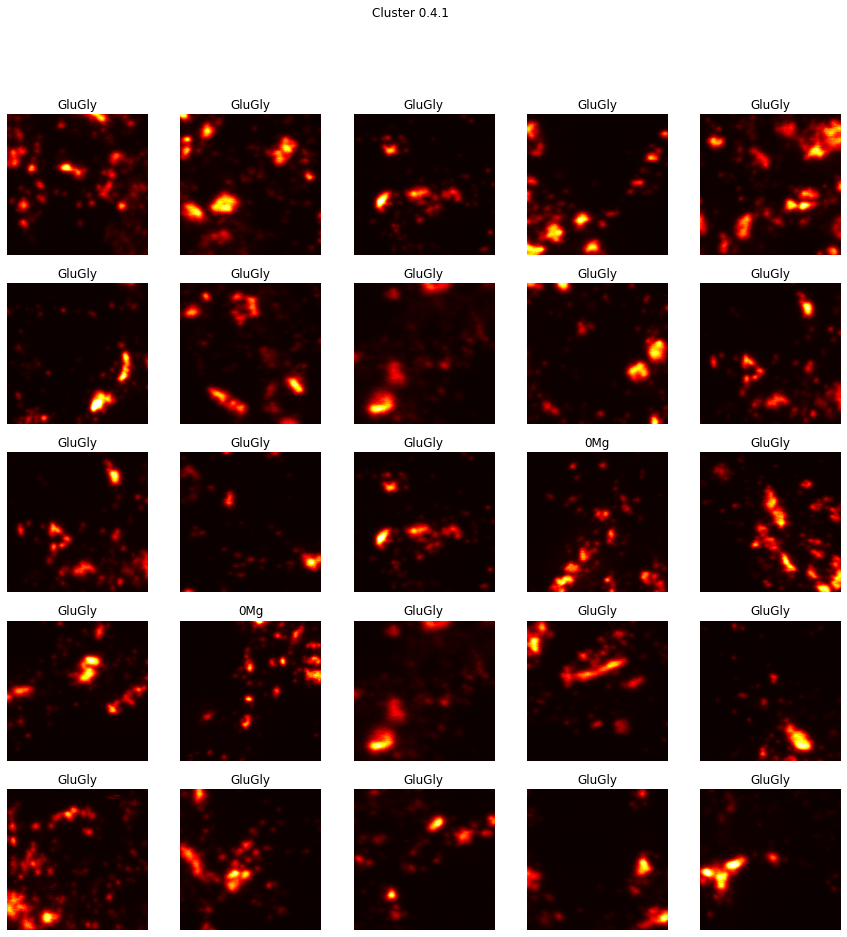

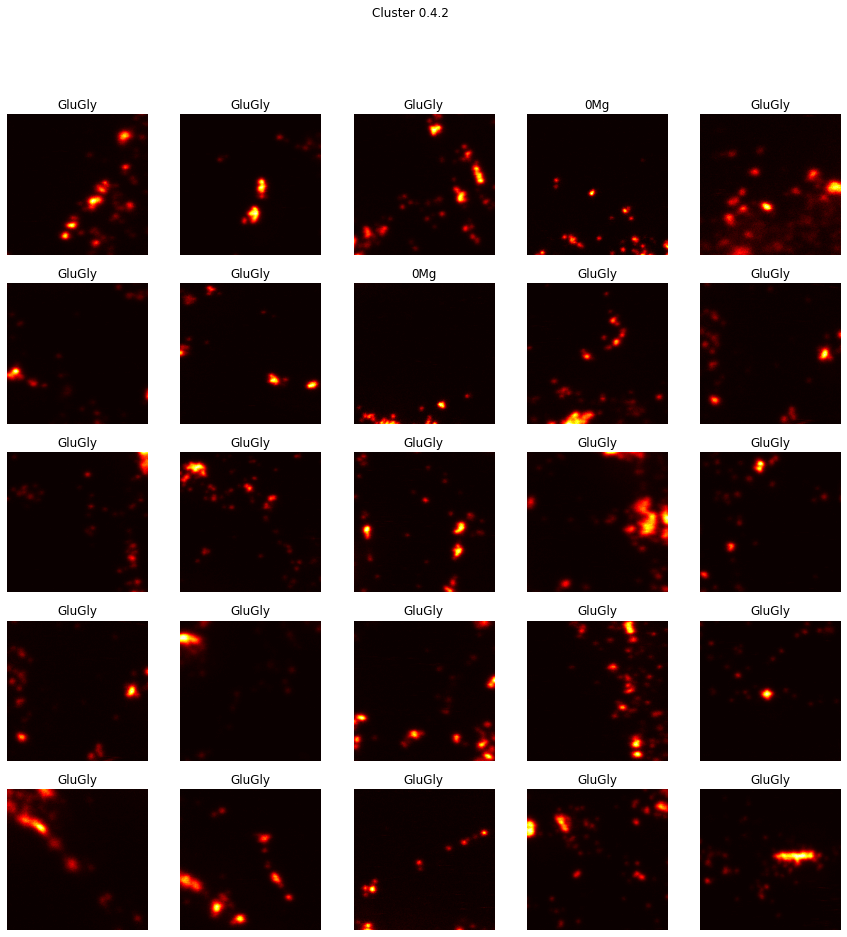

In [20]:
for key in clusters_1.keys():
    clusters = clusters_1[key]
    labels = labels_1[key]
    indices = np.array(depth_1_indices[key])

    show_examples(clusters, dataset_indices=indices, depth=f"{DEPTH}.{key}")

##### Depth 2

1 [19, 5, 2, 4]
2 [11, 11, 17, 22]


<ipython-input-6-968781550c87>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(CLASSES, rotation=25)


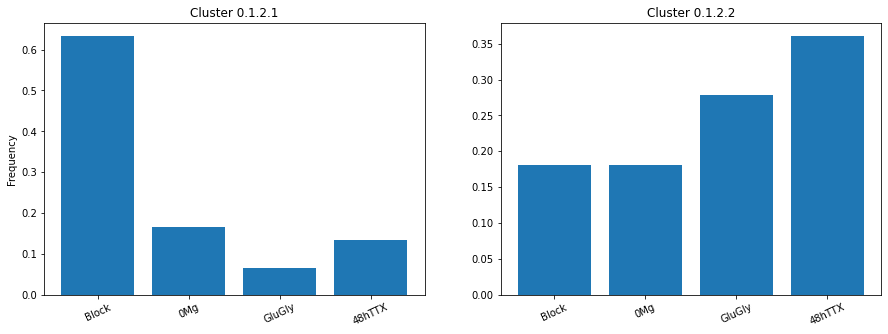

1 [21, 33, 0, 56]
2 [32, 52, 2, 57]


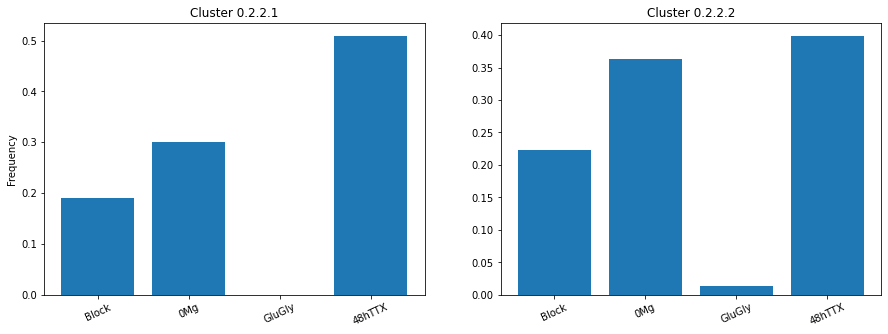

1 [40, 7, 0, 0]
2 [59, 17, 0, 29]


<ipython-input-6-968781550c87>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(CLASSES, rotation=25)


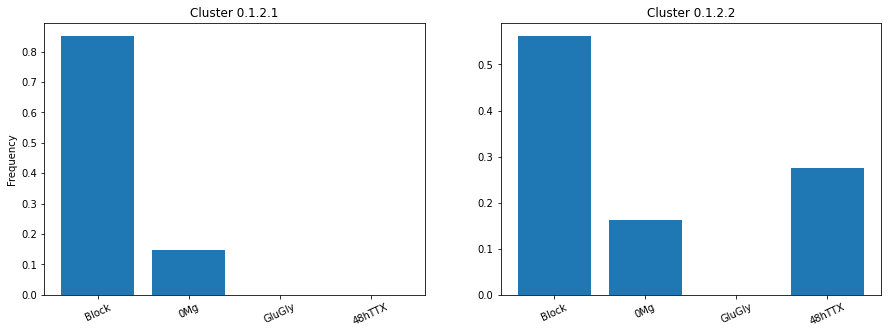

1 [56, 44, 0, 44]
2 [12, 58, 0, 42]


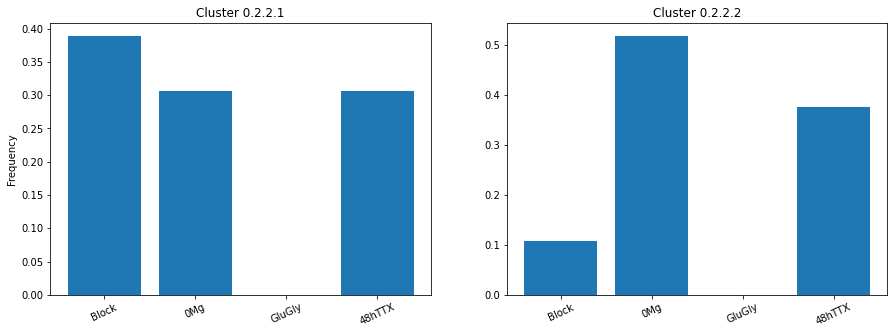

1 [0, 4, 0, 0]
2 [4, 1, 0, 0]


<ipython-input-6-968781550c87>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(CLASSES, rotation=25)


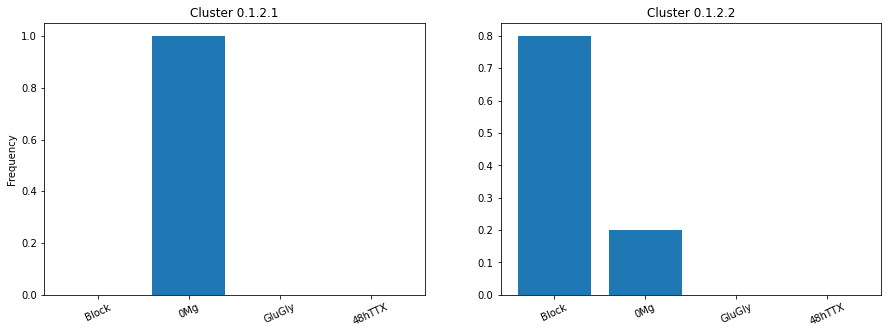

1 [0, 4, 0, 0]
2 [0, 4, 0, 0]


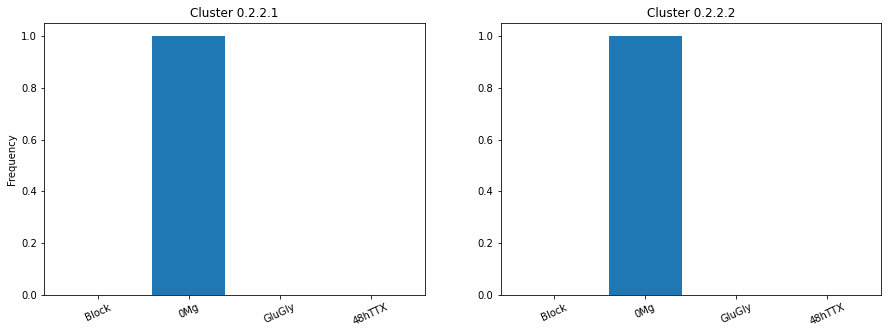

1 [0, 0, 29, 0]
2 [0, 10, 77, 0]


<ipython-input-6-968781550c87>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(CLASSES, rotation=25)


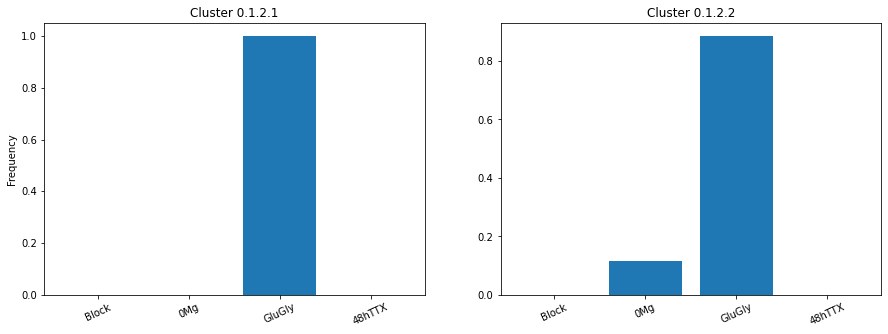

1 [0, 1, 69, 0]
2 [0, 3, 58, 0]


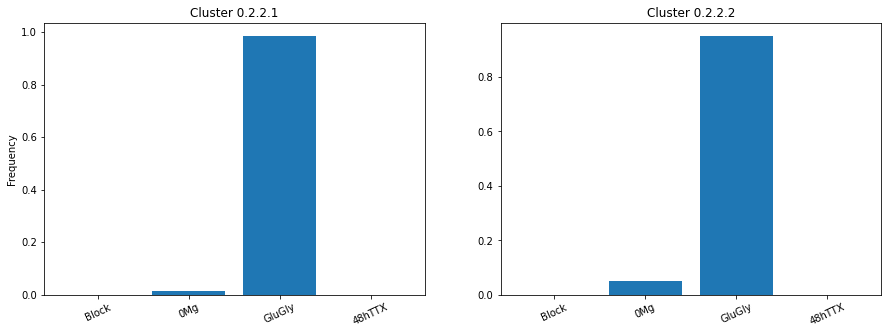

In [22]:
def compute_recursive_clustering(key):
    clusters = clusters_1[key]
    labels = labels_1[key]
    d_indices = np.array(depth_1_indices[key])
    this_depth_indices = {
        key: [] for key in np.unique(clusters)
    }
    this_depth_embeddings = {
        key: None for key in np.unique(clusters)
    }
    this_depth_labels = {
        key: None for key in np.unique(clusters)
    }
    for cluster_id in np.unique(clusters):
        indices = np.where(clusters == cluster_id)[0]
        this_cluster_embeddings = [] 
        cluster_labels = []
        for i, idx in enumerate(indices):
            data_index = d_indices[idx]
            this_depth_indices[cluster_id].append(data_index)
            img = test_loader.dataset[data_index][0]
            label = test_loader.dataset[data_index][1]["label"]
            img = img.unsqueeze(0).to(DEVICE)
            output = model.forward_features(img)
            this_cluster_embeddings.extend(output.data.cpu().numpy())
            cluster_labels.append(label) 
        this_cluster_embeddings = np.array(this_cluster_embeddings)
        cluster_labels = np.array(cluster_labels)
        this_depth_embeddings[cluster_id] = this_cluster_embeddings
        this_depth_labels[cluster_id] = cluster_labels
    
    clusters_2 = {key: cluster_embeddings(this_depth_embeddings[key]) for key in this_depth_embeddings.keys()}
    for key in clusters_2.keys():
        c = clusters_2[key]
        labels = this_depth_labels[key]
        compute_frequencies(c, labels, depth=f"{DEPTH}.{key}.{cluster_id}")


for key in clusters_1.keys():
    compute_recursive_clustering(key)


